In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#  Making Python Faster Part 2

**1**. (25 points) Accelerating network bound procedures.

- Print the names of the first 5 PNG images on the URL `http://people.duke.edu/~ccc14/misc/`. (10 points)
- Write a function that uses a for loop to download all images and time how long it takes (5 points)
- Write a function that uses `concurrent.futures` and a thread pool to download all images and time how long it takes (5 points)
- Write a function that uses `multiprocessing` and a process pool to download all images and time how long it takes (5 points)

In [3]:
import requests
from bs4 import BeautifulSoup


def listFD(url, ext=''):
    '''function to print the names of the png images '''
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + node.get('href') for node in soup.find_all('a') 
            if node.get('href').endswith(ext)]

#list the site and extension 
site = 'http://people.duke.edu/~ccc14/misc/'
ext = 'png'

#print the first first 5 names 
for i, file in enumerate(listFD(site, ext)):
    if i == 5:
        break
    print(file)

http://people.duke.edu/~ccc14/misc/250px-002Ivysaur.png
http://people.duke.edu/~ccc14/misc/250px-003Venusaur.png
http://people.duke.edu/~ccc14/misc/250px-004Charmander.png
http://people.duke.edu/~ccc14/misc/250px-005Charmeleon.png
http://people.duke.edu/~ccc14/misc/250px-006Charizard.png


In [4]:
#function download the images
def download_one(url, path):
    """Function to download one of the png images"""
    r = requests.get(url, stream=True)
    img = r.raw.read()
    with open(path, 'wb') as f:
        f.write(img) 

In [5]:
%%time

#time how long it takes to download them

for url in listFD(site, ext):
    filename = os.path.split(url)[-1]
    download_one(url, filename)

CPU times: user 360 ms, sys: 44 ms, total: 404 ms
Wall time: 9.9 s


In [6]:
%%time

#Write a function that uses concurrent.futures and a thread pool 
from concurrent.futures import ThreadPoolExecutor

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with ThreadPoolExecutor(max_workers=4) as pool:
    pool.map(lambda x: download_one(x[0], x[1]), args)

CPU times: user 304 ms, sys: 60 ms, total: 364 ms
Wall time: 2.58 s


In [7]:
%%time

#Write a function that uses multiprocessing and a process pool to download all images 
from multiprocessing import Pool

args = [(url, os.path.split(url)[-1]) 
        for url in listFD(site, ext)]
with Pool(processes=4) as pool:
    pool.starmap(download_one, args)

CPU times: user 68 ms, sys: 12 ms, total: 80 ms
Wall time: 6.09 s


**2**. (25 points) Accelerating CPU bound procedures

- Use the insanely slow [Buffon's needle](https://en.wikipedia.org/wiki/Buffon's_needle) algorithm to estimate $\pi$.  Suppose the needle is of length 1, and the lines are also 1 unit apart.  Write a function to simulate the dropping of a pin with a random position and random angle, and return 0 if it does not cross a line and 1 if it does. Since the problem is periodic, you can assume that the bottom of the pin falls within (0, 1) and check if it crosses the line `y=0` or `y=1`. (10 points)
- Calculate pi from dropping `n=10^6` pins and time it (10 points)
- Use `concurrent.futures` and a process pool to parallelize  your solution and time it.

In [8]:
n = 100
p = 10
xs = np.random.random((n, p))

In [9]:
def dist(x, y):
    '''Function to return distance between x and y'''
    return np.sqrt(np.sum((x - y)**2))

In [10]:
def pdist(xs):
    m = np.empty((len(xs), len(xs)))
    for i, x in enumerate(xs):
        for j, y in enumerate(xs):
            m[i, j] = dist(x, y)
    return m

In [11]:
%timeit pdist(xs)

10 loops, best of 3: 71.9 ms per loop


In [12]:
import random
import math
#Use Buffon's Needle to estimate pi
def buffons_needle(n):
    """Function to simulate the random dropping of a pin. The pin is length 1. The lines are 1 apart
    Returns 1 if the pin crosses a line and 0 if it does not
    """
    
    #choose random position and angle
    dist_from_closest_line=random.randrange(5)/10
    theta=random.randrange(180)
    
    #determine if the pin crossed a line or not
    if 0.5*math.sin(theta)<=dist_from_closest_line:
        return 1
    else:
        return 0


In [13]:
%%time
n=10**6

#initialize sum to 0
crossed_line=0

#iterate through each n
for i in range(n):
    #if the pin crosses the line, add 1 to the sum
    crossed_line=crossed_line+buffons_needle(i)
    
#then use the resulting sum to estimate pi    
print("Buffon's Needle Estimate of Pi: ", 2*n/crossed_line)

Buffon's Needle Estimate of Pi:  3.151492231571649
CPU times: user 2.77 s, sys: 20 ms, total: 2.79 s
Wall time: 2.81 s


In [14]:
%%time
n=10**5
#Use concurrent.futures and time 

from concurrent.futures import ProcessPoolExecutor

with ProcessPoolExecutor(max_workers=4) as pool:
    pindrops = pool.map(buffons_needle, [int(1e4) for i in range(n)])
    
#sum the list to get the number of needles that crossed a line. Use to estimate Pi    
print("Concurrent.Futures Estimate of Pi:", 2*n/sum(pindrops))

Concurrent.Futures Estimate of Pi: 3.1523366695563086
CPU times: user 22.2 s, sys: 7.86 s, total: 30.1 s
Wall time: 28.2 s


**3**. (25 points) Use C++ to

- Generate 10 $x$-coordinates linearly spaced between 10 and 15
- Generate 10 random $y$-values as $y = 3x^2 − 7x + 2 + \epsilon$ where $\epsilon∼10N(0,1)$
- Find the norm of $x$ and $y$ considered as length 10-vectors
- Find the Euclidean distance between $x$ and $y$
- Solve the linear system to find a quadratic fit for this data

You may wish to use `armadillo` or `eigen` to solve this exercise.

In [15]:
%mkdir question3
%cd question3

mkdir: cannot create directory ‘question3’: File exists
/home/jovyan/work/sta-663-2017/homework/question3


In [16]:
%%file question3.cpp

#include <iostream>
#include <fstream>
#include <armadillo>

using std::cout;
using std::ofstream;

int main() 
{
    using namespace arma;
    // Create x, y, and e
    vec X = linspace<vec>(10.0,15.0,10);
    vec e = randn<vec>(10);
    vec Y = 3*X%X - 7*X + 2 + 10*e; 

    // Find the norm of X, Y
    cout << "X Values: \n " << X << "\n";
    cout << "Y Values: \n " << Y << "\n";
    cout << "X Length: \n " << norm(X) << "\n \n";
    cout << "Y Length: \n " << norm(Y) << "\n \n";
    
    // Find the Distance between the 2
    cout << "Euclidean distance between X and Y: \n" << norm(X - Y) << "\n \n";
    
    // create the matrix to solve the quadratic fit
    mat new_X = join_rows(ones<vec>(10), X);
    new_X = join_rows(new_X,X%X);

    // Solve for beta
    vec beta = solve(new_X, Y);
    cout << "Beta Values for Quadratic Fit: \n" << beta << "\n";
}

Overwriting question3.cpp


In [17]:
%%file Makefile
# Declaration of variables
CC = g++
CC_FLAGS = -Wall -std=c++11
LD_FLAGS = -larmadillo # Add library for linking

# File names
EXEC = question3
SOURCES = $(wildcard *.cpp)
OBJECTS = $(SOURCES:.cpp=.o)
 
# Main target
$(EXEC): $(OBJECTS)
	$(CC) $(LD_FLAGS) $(OBJECTS) -o $(EXEC)
 
# To obtain object files
%.o: %.cpp
	$(CC) -c $(CC_FLAGS) $< -o $@
 
# To remove generated files
clean:
	rm -f $(EXEC) $(OBJECTS)

Overwriting Makefile


In [18]:
%%bash

make clean
make
./question3

rm -f question3 question3.o
g++ -c -Wall -std=c++11 question3.cpp -o question3.o
g++ -larmadillo  question3.o -o question3
X Values: 
    10.0000
   10.5556
   11.1111
   11.6667
   12.2222
   12.7778
   13.3333
   13.8889
   14.4444
   15.0000

Y Values: 
    2.2513e+02
   2.7027e+02
   2.9660e+02
   3.2962e+02
   3.6404e+02
   3.9959e+02
   4.2064e+02
   4.8632e+02
   5.3136e+02
   5.5517e+02

X Length: 
 39.8493
 
Y Length: 
 1271.44
 
Euclidean distance between X and Y: 
1232
 
Beta Values for Quadratic Fit: 
  -66.5216
    5.6618
    2.4158



**4**. (25 points) **4**. Write a C++ function that uses the `eigen` library to solve the least squares linear problem

$$
\beta = (X^TX)^{-1}X^Ty
$$

for a matrix $X$ and vector $y$ and returns the vector of coefficients $\beta$. Wrap the function for use in Python and call it like so

```
beta <- least_squares(X, y)
```

where $X$ and $y$ are given below. 

Wrap the function so that it can be called from Python and compare with the `np.linalg.lstsq` solution shown.

In [19]:
n = 10
x = np.linspace(0, 10, n)
y = 3*x**2 - 7*x + 2 + np.random.normal(0, 10, n)
X = np.c_[np.ones(n), x, x**2]

In [20]:
beta = np.linalg.lstsq(X, y)[0]

In [21]:
beta

array([-4.33058184, -2.04475907,  2.35964587])

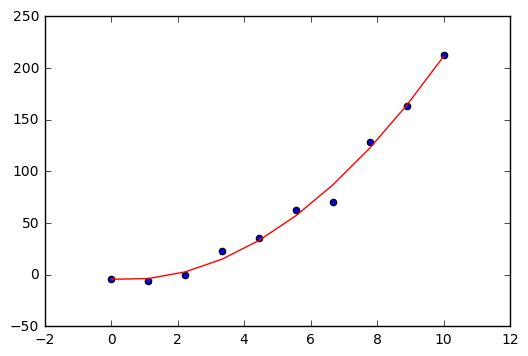

In [22]:
plt.scatter(x, y)
plt.plot(x, X @ beta, 'red')
pass

In [23]:
! pip3 install pybind11
! pip3 install cppimport

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
! git clone https://github.com/RLovelett/eigen.git

Cloning into 'eigen'...
remote: Counting objects: 88374, done.
remote: Compressing objects: 100% (405/405), done.
remote: Total 88374 (delta 257), reused 0 (delta 0), pack-reused 87969
Receiving objects: 100% (88374/88374), 71.56 MiB | 28.93 MiB/s, done.
Resolving deltas: 100% (65215/65215), done.
Checking connectivity... done.


In [25]:
%mkdir question4
%cd question4

mkdir: cannot create directory ‘question4’: File exists
/home/jovyan/work/sta-663-2017/homework/question3/question4


In [26]:
%%file wrap6.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['../eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/eigen.h>
#include <Eigen/Dense>

using namespace Eigen;
namespace py = pybind11;


// Calculates the least squares using Eigen
Eigen::MatrixXd least_squares(Eigen::MatrixXd xs,Eigen::MatrixXd b) {
    return xs.jacobiSvd(ComputeThinU | ComputeThinV).solve(b);
}

PYBIND11_PLUGIN(wrap6) {
    pybind11::module m("wrap6", "auto-compiled c++ extension");
    m.def("least_squares", &least_squares);
    return m.ptr();
}

Overwriting wrap6.cpp


In [27]:
import cppimport
import numpy as np

code = cppimport.imp("wrap6")

#try the least_squares function
beta2=code.least_squares(X,y)

#print both this beta and the linalg beta to check for correctness. They're the same
print(beta)
print(beta2.T)

[-4.33058184 -2.04475907  2.35964587]
[[-4.33058184 -2.04475907  2.35964587]]


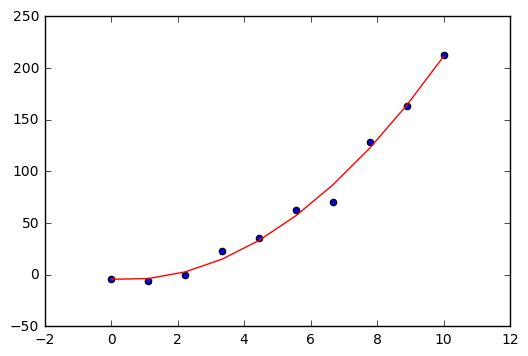

In [28]:
#Scatter the new beta2
plt.scatter(x, y)
plt.plot(x, X @ beta2, 'red')
pass